In [10]:
pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=e2da6a345efa0354e26a00c9e1d3d97de7a86dc218e34be4f4bf03bf12518b86
  Stored in directory: c:\users\chris\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.0
    Uninstalling importlib-metadata-3.10.0:
      Successfully uninstalled importlib-metadata-3.10.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
import plotly.express as px #version=4.14.0

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import Dense,CuDNNLSTM, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math 

In [3]:
config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [4]:
df = pd.read_csv("Downloads/airline-passengers.csv", usecols=['Passengers'])
df.tail()

,Passengers
139,606
140,508
141,461
142,390
143,432


In [9]:
df.head(10)

,Passengers
0,112
1,118
2,132
3,129
4,121
5,135
6,148
7,148
8,136
9,119


In [11]:
def denormalize(data):
    return scaler.inverse_transform(data)

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# convert an numpy array into a new dataset matrix
def create_new_dataset(data, lag=1):
    X, Y = [],[]
    for i in range(len(data)-lag):
        X.append(data[i: i+lag])
        Y.append(data[i+lag])
    return np.array(X), np.array(Y)

In [12]:
t = np.linspace(0,144,144)
fig = px.line(df.reset_index(), x = t, y = 'Passengers', title= 'Airline Passenger trend')
fig.update_xaxes(rangeslider_visible= True)
line_type = "dash"
c= "green"
fig.add_vline(x=12 , line_dash=line_type, line_color=c)
fig.add_vline(x=24 , line_dash=line_type, line_color=c)
fig.add_vline(x=36 , line_dash=line_type, line_color=c)
fig.add_vline(x=120 , line_dash=line_type, line_color=c)
fig.show()

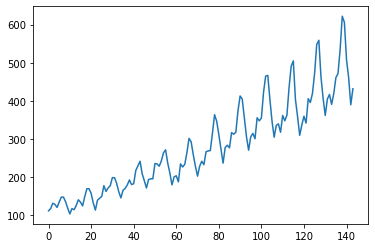

In [13]:
from matplotlib import pyplot
pyplot.plot(df)
pyplot.show()

In [14]:
#fixing random seed 
np.random.seed(0)
#convert int to float as it's more suitable for modelling
data = df.values.astype('float64')

In [15]:
#normalize dataset 
#LSTMs are sensitive to scale of input data
scaler = MinMaxScaler()
scaled_data= scaler.fit_transform(data)

In [16]:
#train_test_split
train_size = int(len(scaled_data)*.67)# 67:33 split 
train,test = scaled_data[0:train_size],scaled_data[train_size:]


In [17]:
# reshape into X=t and Y=t+1
lag = 1 # default is kept as one 
x_train, y_train = create_new_dataset(train, lag)
x_test, y_test = create_new_dataset(test, lag)

In [18]:
#LSTM needs input data with format [samples, time steps and features]
x_train =np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1])) #[94,1,1]
x_test =np.reshape(x_test,(x_test.shape[0], 1 ,x_test.shape[1])) #[46,1,1]

### Building the model

In [19]:
# LSTM network architecture
model = Sequential()
model.add(LSTM(4, input_shape=(1, lag)))
model.add(Dense(1))
model.summary()
#compile
model.compile(loss='mean_squared_error', optimizer='adam')
#train
model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
95/95 - 2s - loss: 0.0498 - 2s/epoch - 23ms/step
Epoch 2/100
95/95 - 0s - loss: 0.0236 - 120ms/epoch - 1ms/step
Epoch 3/100
95/95 - 0s - loss: 0.0186 - 118ms/epoch - 1ms/step
Epoch 4/100
95/95 - 0s - loss: 0.0175 - 123ms/epoch - 1ms/step
Epoch 5/100
95/95 - 0s - loss: 0.0163 - 109ms/epoch - 1ms/step
Epoch 6/100
95/95 - 0s - loss: 0.0150 - 117ms/epoch - 1ms/step
Epoch 7/100
95/95 - 0s - loss: 0.0140 - 142ms/epoch - 1ms/step
Epoch 8/100
95/

### Predictions and denormalize

In [20]:
# making predictions
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

# invert predictions to denormalize
train_pred = denormalize(train_pred)
y_train = denormalize(y_train)

test_pred = denormalize(test_pred)
y_test= denormalize(y_test)

In [21]:
# EVALUATING
# root mean squared error
train_score = measure_rmse(y_train, train_pred[:,0])
print('Train RMSE: %.2f' % (train_score))

test_score = measure_rmse(y_test, test_pred[:,0])
print('Test RMSE: %.2f' % (test_score))

Train RMSE: 23.45
Test RMSE: 49.18


In [22]:
#Plotting predicted data
train_pred_plot= np.empty_like(data)
train_pred_plot[:, :] = np.nan
train_pred_plot[lag:len(train_pred)+lag,:] = train_pred

# shift test predictions for alignment
test_pred_plot = np.empty_like(data)
test_pred_plot[:, :] = np.nan
test_pred_plot[len(train_pred)+(lag*2):len(data), :] = test_pred

df['train_pred'] = train_pred_plot
df['test_pred'] = test_pred_plot

In [23]:
t = np.linspace(0,144,144)
fig = px.line(df.reset_index(), x = t, y = ['Passengers', 'train_pred', 'test_pred'], title= 'Airline Passenger trend')
fig.update_xaxes(rangeslider_visible= True)


In [24]:
#Prediction using last 2 months and current month
new_df = pd.DataFrame()
new_df['x1']= df['Passengers']
new_df['x2']= df['Passengers'].shift(-1)
new_df['x3']= df['Passengers'].shift(-2)
new_df['y']= df['Passengers'].shift(-3)
new_df.dropna(inplace =True)
new_df

,x1,x2,x3,y
0,112,118.0,132.0,129.0
1,118,132.0,129.0,121.0
2,132,129.0,121.0,135.0
3,129,121.0,135.0,148.0
4,121,135.0,148.0,148.0
...,...,...,...,...
136,472,535.0,622.0,606.0
137,535,622.0,606.0,508.0
138,622,606.0,508.0,461.0
139,606,508.0,461.0,390.0


In [25]:
# reshape into X=t and Y=t+1
lag = 3 # default is kept as one 
x_train, y_train = create_new_dataset(train, lag)
x_test, y_test = create_new_dataset(test, lag)

#LSTM needs input data with format [samples, time steps and features]
x_train =np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1])) #[93,1,3]
x_test =np.reshape(x_test,(x_test.shape[0], 1 ,x_test.shape[1])) #[45,1,3]

# LSTM network architecture
model = Sequential()
model.add(LSTM(4, input_shape=(1, lag)))
model.add(Dense(1))
model.summary()
#compile
model.compile(loss='mean_squared_error', optimizer='adam')
#train
model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=0)

# making predictions
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

# invert predictions to denormalize
train_pred = denormalize(train_pred)
y_train = denormalize(y_train)

test_pred = denormalize(test_pred)
y_test= denormalize(y_test)

# root mean squared error
train_score = measure_rmse(y_train, train_pred[:,0])
print('Train RMSE: %.2f' % (train_score))

test_score = measure_rmse(y_test, test_pred[:,0])
print('Test RMSE: %.2f' % (test_score))


train_pred_plot= np.empty_like(data)
train_pred_plot[:, :] = np.nan
train_pred_plot[lag:len(train_pred)+lag,:] = train_pred

# shift test predictions for alignment
test_pred_plot = np.empty_like(data)
test_pred_plot[:, :] = np.nan
# test_pred_plot[len(train_pred)+(lag*2):len(data), :] = test_pred
test_pred_plot[len(train_pred)+(lag*2):len(data), :] = test_pred

df['train_pred_3'] = train_pred_plot
df['test_pred_3'] = test_pred_plot

t = np.linspace(0,144,144)
fig = px.line(df.reset_index(), x = t, y = ['Passengers', 'train_pred_3', 'test_pred_3'], title= 'Airline Passenger trend')
fig.update_xaxes(rangeslider_visible= True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4)                 128       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________
Train RMSE: 23.59
Test RMSE: 50.04
